In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
epochs=30
learning_rate=0.01
batch_size_train=1
batch_size_test=1

momentum=0.5
log_interval=10



random_seed=1
torch.backends.cudnn.enabled=True
torch.manual_seed(random_seed)

In [5]:
import pandas as pd
import glob

path = '/kaggle/input/aaih-assignment-3/'
filename = 'train.csv'
train_path = path + filename
csv_data=train_path
csv1_data = pd.read_csv(train_path)
csv1_data.head()

,id,binary_pred,segmentation_pred
0,image_373.png,1,19525 3 19763 7 20001 11 20240 14 20479 17 207...
1,image_1926.png,0,Healthy
2,image_681.png,0,Healthy
3,image_2073.png,0,Healthy
4,image_949.png,1,19119 3 19357 6 19597 6 19836 7 20076 7 20316 ...


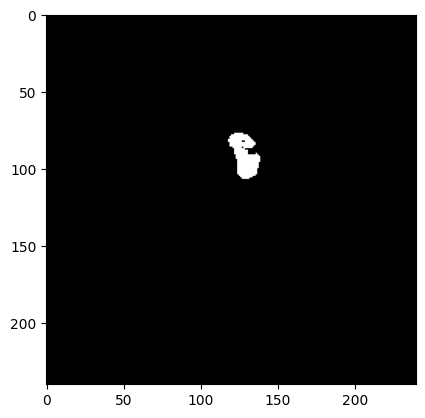

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

pathtodownload_masks='/kaggle/input/aaih-assignment-3/train/masks/'

img1=pathtodownload_masks+'mask_7.png'
img = cv.imread(img1)
plt.imshow(img)

In [7]:
import pandas as pd
import numpy as np
from PIL import Image, ImageChops
import cv2 as cv
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.transforms as transforms
pathtodownload_image = '/kaggle/input/aaih-assignment-3/train/images/'
pathtodownload_masks='/kaggle/input/aaih-assignment-3/train/masks/'

class CustomDataset(Dataset):
    def __init__(self,dataframe):
        self.df = dataframe.reset_index(drop = True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path= pathtodownload_image + self.df.loc[idx, 'id']
        image = cv.imread(img_path)
        x=self.df.loc[idx,'id']
        x=x[6:-4]
        
        mask_path = os.path.join(pathtodownload_masks, 'mask_' + str(x) + '.png')
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        # print(mask_path)
        
        if mask is None:
            print(f"Warning: Unable to read mask image at {mask_path}")
            mask = np.zeros_like(image)  # or some default value

        mask_image = Image.fromarray(mask)
        inv_mask = ImageChops.invert(mask_image)

        image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
        mask_transform = transforms.Compose([transforms.ToTensor()])

        
        if image_transform:
            image = image_transform(image)
        if mask_transform:
            mask_image = mask_transform(mask_image)
            inv_mask = mask_transform(inv_mask)

        return image, mask_image, inv_mask




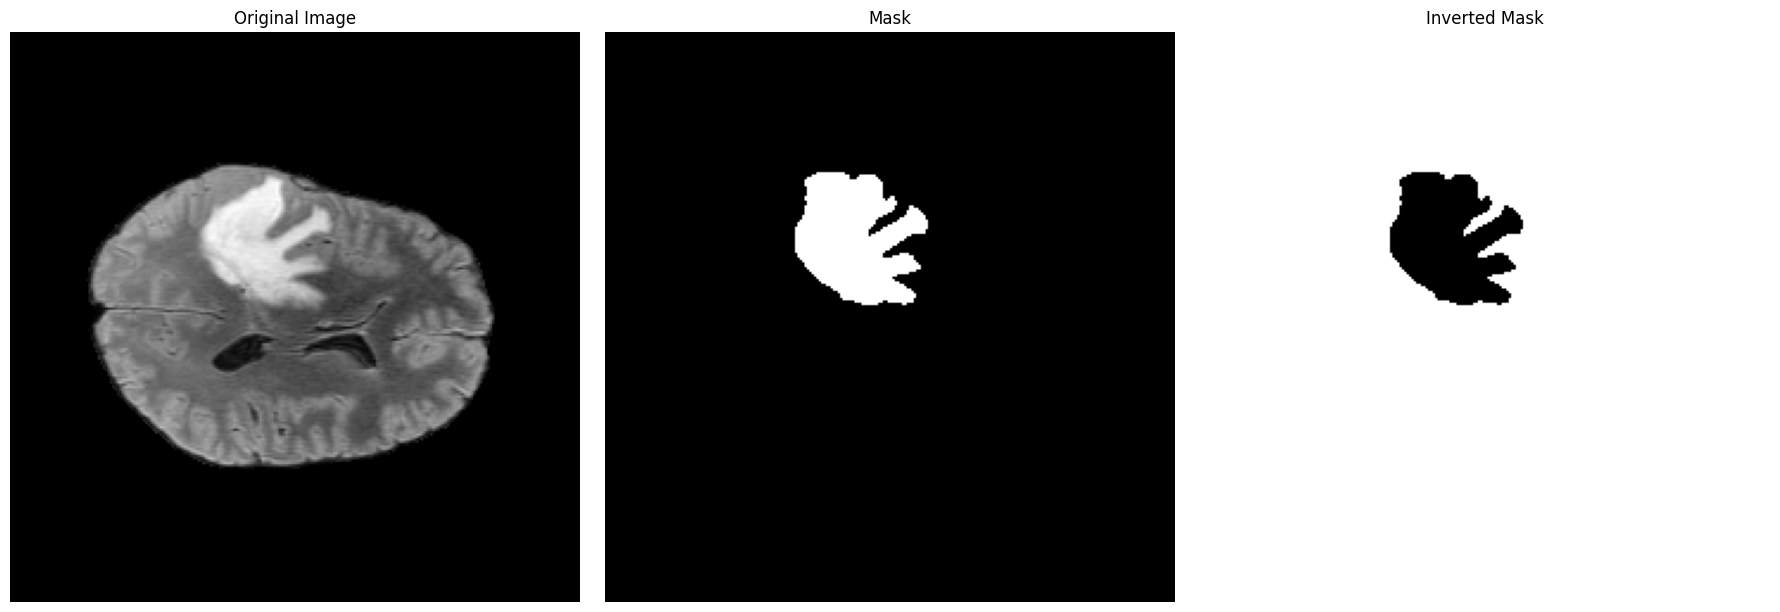

In [8]:
import matplotlib.pyplot as plt

# Assuming you have already defined the dataset and retrieved an example
dataset = CustomDataset(csv1_data)
image, mask, inv_mask = dataset.__getitem__(25)
image = image.permute(1,2,0) 
image=image*.5+0.5
mask = mask.permute(1,2,0) 
inv_mask = inv_mask.permute(1,2,0)
# Create a figure with 1 row and 3 columns
plt.figure(figsize=(18, 6))

# First subplot for the original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')  # Turn off axis labels

# Second subplot for the mask
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')  # Display the mask in grayscale
plt.title('Mask')
plt.axis('off')  # Turn off axis labels

# Third subplot for the inverted mask
plt.subplot(1, 3, 3)
plt.imshow(inv_mask, cmap='gray')  # Display the inverted mask in grayscale
plt.title('Inverted Mask')
plt.axis('off')  # Turn off axis labels

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()




In [9]:
from sklearn.model_selection import train_test_split
df=pd.read_csv(train_path)

X=df[['id','segmentation_pred']]

X_train,X_test = train_test_split(X,test_size=0.05,random_state=0)

train_dataset=CustomDataset(X_train)
test_dataset = CustomDataset(X_test)

batch_size_train = 16
batch_size_test = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
print(train_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

examples = next(iter(train_loader))
print(examples[0].size(), examples[1].size())


torch.Size([16, 3, 240, 240]) torch.Size([16, 1, 240, 240])


In [10]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu



In [11]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.7 MB/s eta 0:00:00a 0:00:01


In [12]:
import monai 
print(monai.__version__)

2024-07-12 09:08:27.730152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 09:08:27.730268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 09:08:27.861352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1.3.2


In [13]:
from monai.networks.nets import UNet

# 3 layer network with down/upsampling by a factor of 2 at each layer with 2-convolution residual units
network = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2
).to(device) 

In [14]:

optimizer=optim.SGD(network.parameters(),lr=learning_rate,momentum=momentum)


In [15]:
total_params = 0
for params in network.parameters():
    total_params += params.numel()
print(total_params)

6288


In [16]:
train_losses=[]
train_counter=[]
test_losses=[]
test_counter=[i*len(train_loader.dataset) for i in range(epochs+1)]

In [17]:
from monai .losses.dice import *
from monai.losses.dice import DiceLoss
def train(epoch):
    network.train()
    for batch_idx, (data, target1,target2) in enumerate(train_loader):
        data, target1,target2 = data.to(device), target1.to(device),target2.to(device)  # Move data and target to GPU
        optimizer.zero_grad()
        output = network(data)
        self = DiceLoss(sigmoid=True,reduction='mean')
        loss = self(output, target1)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size_train) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results.pt')
            torch.save(optimizer.state_dict(), 'optimizer.pt')


In [18]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target1,target2 in test_loader:
            data, target1,target2 = data.to(device), target1.to(device) ,target2.to(device) # Move data and target to GPU
            output = network(data)            
            test_loss += F.cross_entropy(output, target1, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target1.data.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target1.cpu().numpy())
        
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, int(correct/(256*256)), len(test_loader.dataset),100. * correct / (len(test_loader.dataset)*256*256)))
        
    
    return all_preds, all_targets


In [19]:
torch.cuda.empty_cache()

In [20]:
# test()
for epoch in range(1,epochs+1):
    train(epoch)
    test()

Train Epoch: 1 [0/3144 (0%)]	Loss: 0.951086
Train Epoch: 1 [160/3144 (5%)]	Loss: 0.954043
Train Epoch: 1 [320/3144 (10%)]	Loss: 0.966053
Train Epoch: 1 [480/3144 (15%)]	Loss: 0.938102
Train Epoch: 1 [640/3144 (20%)]	Loss: 0.943595
Train Epoch: 1 [800/3144 (25%)]	Loss: 0.954191
Train Epoch: 1 [960/3144 (30%)]	Loss: 0.929357
Train Epoch: 1 [1120/3144 (36%)]	Loss: 0.933232
Train Epoch: 1 [1280/3144 (41%)]	Loss: 0.929109
Train Epoch: 1 [1440/3144 (46%)]	Loss: 0.928279
Train Epoch: 1 [1600/3144 (51%)]	Loss: 0.945028
Train Epoch: 1 [1760/3144 (56%)]	Loss: 0.943351
Train Epoch: 1 [1920/3144 (61%)]	Loss: 0.944016
Train Epoch: 1 [2080/3144 (66%)]	Loss: 0.942750
Train Epoch: 1 [2240/3144 (71%)]	Loss: 0.927054
Train Epoch: 1 [2400/3144 (76%)]	Loss: 0.966400
Train Epoch: 1 [2560/3144 (81%)]	Loss: 0.935708
Train Epoch: 1 [2720/3144 (86%)]	Loss: 0.904951
Train Epoch: 1 [2880/3144 (91%)]	Loss: 0.938943
Train Epoch: 1 [3040/3144 (96%)]	Loss: 0.911009

Test set: Avg. loss: 0.0000, Accuracy: 142/166 (86

In [40]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch import tensor 
from torchmetrics.classification import Dice

# Assuming test() function returns predicted and true labels
all_preds, all_targets = test()

# Flatten the arrays
all_preds_flat = np.concatenate([pred.flatten() for pred in all_preds])
all_targets_flat = np.concatenate([target.flatten() for target in all_targets])

# Calculate precision, recall, and F1 score
precision = precision_score(all_targets_flat, all_preds_flat, average='weighted', zero_division=1)
recall = recall_score(all_targets_flat, all_preds_flat, average='weighted', zero_division=1)
f1 = f1_score(all_targets_flat, all_preds_flat, average='weighted', zero_division=1)

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

dice = Dice(average="micro")

# Extract last predictions and targets
x = preds[-1]
y = target[-1]

# Convert numpy arrays to tensors
t = torch.from_numpy(x).to(torch.int32)
z = torch.from_numpy(y).to(torch.int32)

# Calculate Dice coefficient
dice_score = dice(t, z)
print(f"Dice coefficient: {dice_score.item()}")




Test set: Avg. loss: 0.0000, Accuracy: 142/166 (86%)

Precision: 0.9804
Recall: 0.9800
F1 Score: 0.9701
Dice coefficient: 1.0


In [1]:
import matplotlib.pyplot as plt

# Get a batch of test data
examples = next(iter(test_loader))
example_data, example_target,_ = examples

# Move the data to the device
example_data = example_data.to(device)
example_target = example_target.to(device)

# Perform a forward pass through the network to get the predictions
with torch.no_grad():
    output = network(example_data)

# Plot the results
fig = plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(3, 6, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Image")
    plt.xticks([])
    plt.yticks([])


    plt.subplot(3, 6, i + 7)
    plt.tight_layout()
    plt.imshow(example_target[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 6, i + 13)
    plt.tight_layout()
    plt.imshow(output[i].squeeze().cpu().numpy()>0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.xticks([])
    plt.yticks([])

plt.show()


NameError: name 'test_loader' is not defined